In [17]:
%matplotlib inline
import matplotlib as mpl
plt = mpl.pyplot
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
import numpy as np
import utils

In [3]:
# Load data
# I named it differently just to type faster
x_train, y_train, x_test, y_test = utils.get_training_data(0.1, onehot=0)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))

(18000, 1000) (18000,) (2000, 1000) (2000,)
0.5054444444444445 0.5045


In [4]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
x_train = tfidf.fit_transform(x_train)
x_test = tfidf.transform(x_test)

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
n_estimators = 4000
learning_rate = 0.05
# dt1 = DecisionTreeClassifier(max_depth=1)
dt2 = DecisionTreeClassifier(max_depth=2)
# ada1 = AdaBoostClassifier(base_estimator=dt1, n_estimators=n_estimators, 
#                         learning_rate=learning_rate)
ada2 = AdaBoostClassifier(base_estimator=dt2, n_estimators=n_estimators, 
                        learning_rate=learning_rate)

In [19]:
# ada1.fit(x_train, y_train)
ada2.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.05, n_estimators=4000, random_state=None)

In [9]:
from sklearn.metrics import zero_one_loss
def plot_ada_hist(ada, title):
    ada_acc = np.zeros((n_estimators,))
    for i, y_pred in enumerate(ada.staged_predict(x_test)):
        ada_acc[i] = zero_one_loss(y_pred, y_test)

    ada_acc_train = np.zeros((n_estimators,))
    for i, y_pred in enumerate(ada.staged_predict(x_train)):
        ada_acc_train[i] = zero_one_loss(y_pred, y_train)

    plt.figure(dpi=300)
    plt.plot(np.arange(n_estimators) + 1, ada_acc, label='AdaBoost Test Loss')
    plt.plot(np.arange(n_estimators) + 1, ada_acc_train, label='AdaBoost Train Loss')
    plt.semilogy()
    plt.legend()
    plt.title(title)
    plt.show()
    plt.clf()

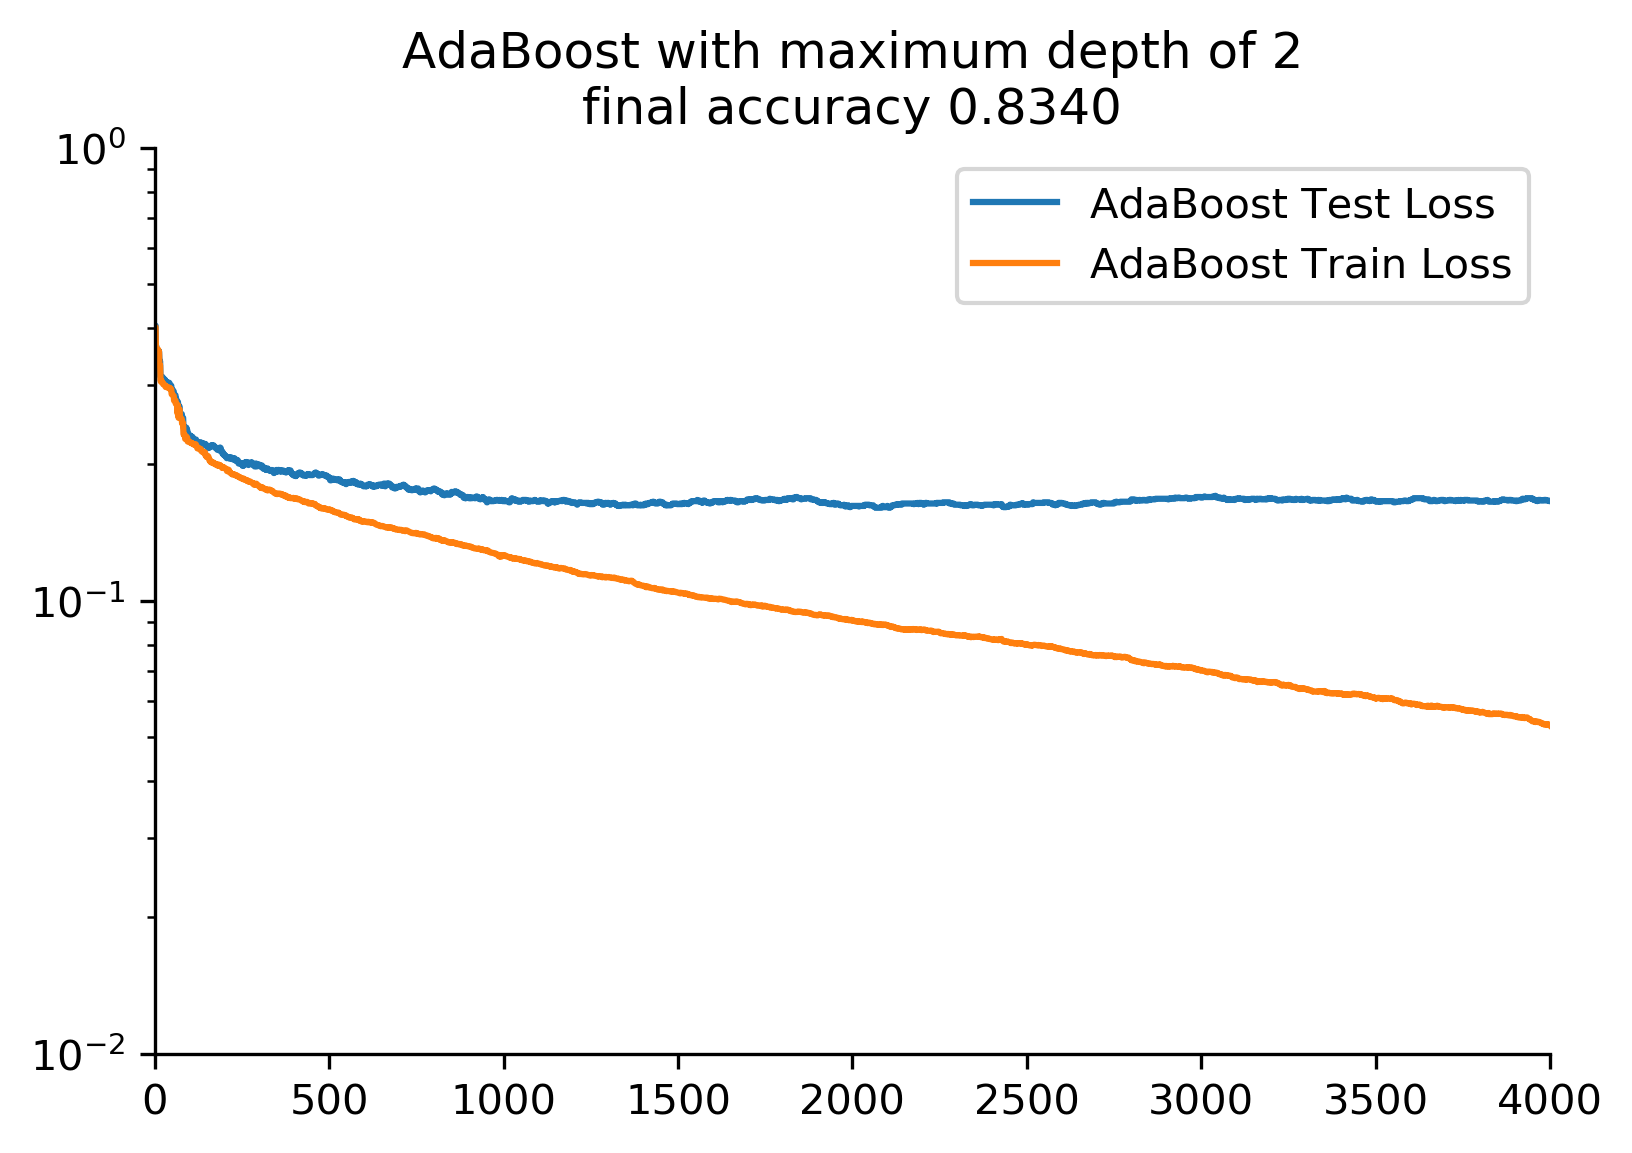

In [20]:
plot_ada_hist(ada2, 'AdaBoost with maximum depth of 2\nfinal accuracy %.4f'
             %ada2.score(x_test, y_test))

In [41]:
def get_test_data():
    """
    Loads the training data, splits it into training and validation sets, and
    converts the labels into 2-class one-hot encoding

    :param validation_size: What ratio of the dataset to use as training data
    :param use_one_hot_encoding: Whether to use one hot encoding
    :return: (training_features, training_labels,
        validation_features, validation_labels)
    """

    data = np.loadtxt(
        "data/test_data.txt", skiprows=1, delimiter=" ")

    training_features = data[:, :]

    return training_features

In [44]:
x_test_final = get_test_data()
print(x_test_final.shape)
x_test_final = tfidf.transform(x_test_final)

(10000, 1000)


In [45]:
y_test_final = ada2.predict(x_test_final)
print(y_test_final.shape, np.min(y_test_final), np.max(y_test_final))

(10000,) 0.0 1.0


In [53]:
N = y_test_final.size
test_labels = np.vstack((np.arange(1, N+1), y_test_final)).transpose()
np.savetxt('data/sample_submission.txt', test_labels, fmt=('%d', '%d'), delimiter=',',
          header='Id,Prediction', comments='')